In [1]:
%matplotlib inline
%pdb on
%run _547

Automatic pdb calling has been turned ON


# System model
Consider the simple pendulum model (see [1])
$$m\ddot{a} = -\frac{mg}{l} \sin(a) + \tau$$
where $a$ is pendulum angle, $l$ is rod length, $m$ is pendulum mass, $g$ is force due to gravity, and $\tau$ is an input torque arising from a motor attached to the rod at its pivot point.

If we measure or observe the pendulum angle (e.g. with an encoder on the pivot motor), then the ODE control system model is
$$\dot{x} = f(x,u),\ y = h(x)$$
where $x = (a,\dot{a})\in\mathbb{R}^2$, $u = \tau\in\mathbb{R}$, $f : \mathbb{R}^2 \times \mathbb{R} \rightarrow \mathbb{R}^2$ is defined by 
$$f((a,\dot{a}),u) = (\dot{a},\ddot{a}) = (\dot{a}, -\frac{g}{l} \sin(a) + \frac{1}{m}u),$$ 
and $h : \mathbb{R}^2 \rightarrow \mathbb{R}$ is defined by 
$$h(a,\dot{a}) = a.$$

    [1]: https://en.wikipedia.org/wiki/Pendulum_(mathematics)

# Simulation
To simulate the pendulum, we first implement Python versions of the ODE control system model; it'll be computationally expedient if both $f$ and $h$ accept $t$, $x$, and $u$ as arguments even though mathematically they may not depend on all three:

In [47]:
import numpy as np

g,l,m = 9.81,.5,1. # m/sec^2, m, kg

def f(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([da,-(g/l)*np.sin(a) + (1/m)*u])

def h(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return a # output only the angle

Then we define the simulation algorithm:

In [48]:
def sim(f,t,x,u=lambda t:0.,dt=1e-4):
    j,t_,x_ = 0,[0],[x]
    while j*dt < t:
        t_.append((j+1)*dt)
        x_.append(x_[-1] + dt*f(j*dt,x_[-1],u(j*dt)))
        j += 1
    return np.array(t_),np.array(x_)

Note that $x_0 = (0,0)$ (i.e. zero angle and zero velocity) is an equilibrium:

In [49]:
x0 = [0,0]
print 'f(x0) =',f(0.,x0,0)

f(x0) = [ 0.  0.]


Now we can simulate and plot the result; recall that, for small angles, the period of the pendulum swing is (approximately) $2\pi\sqrt{l/g}$:

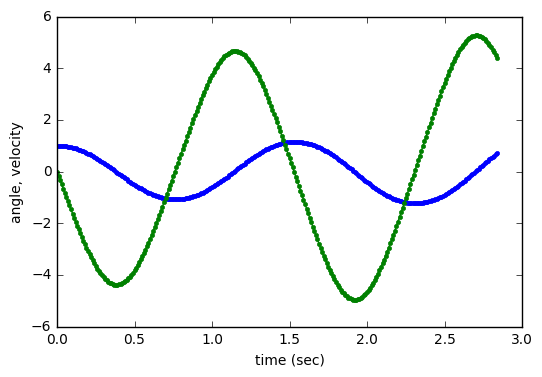

In [85]:
%matplotlib inline

import pylab as plt

t1 = 2*(2*np.pi*np.sqrt(l/g)) # approximately 2 periods
x1 = [1.,0.] # "interesting" initial condition
u1 = lambda t : 0 # zero input function

t_,x_ = sim(f,t1,x1,u1,dt=1e-2)
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. angle and velocity) at time t_[j]

plt.plot(t_,x_,'.-')
plt.xlabel('time (sec)')
plt.ylabel('angle, velocity')

Recall from physics that the change in potential and kinetic energies are
$$PE = mgl\cos(a),\ KE =\frac{1}{2}m(l\dot{a})^2,$$
and that, in the absence of exogeneous input, any change in PE must be matched by an opposite change in KE, so PE - KE = 0.

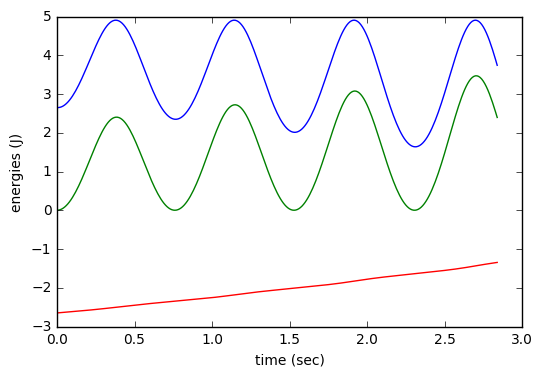

In [86]:
def E(x_):
    a,da = x_.T # angle (rad), velocity (rad/sec)
    PE,KE = m*(g*l)*(np.cos(a)),.5*m*(l*da)**2 # potential, kinetic energy
    return np.array([PE,KE,KE-PE])

plt.plot(t_,E(x_).T);
plt.xlabel('time (sec)');
plt.ylabel('energies (J)');

Looks good, but let's zoom in on that red curve (total change in energy):

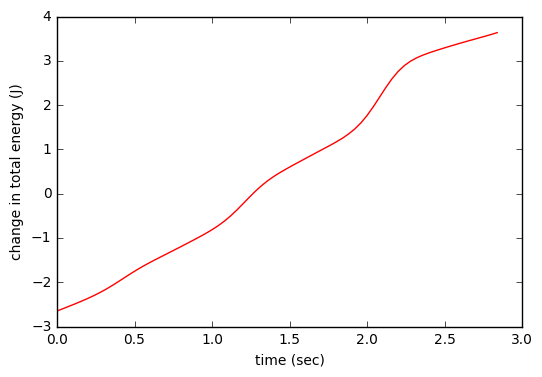

In [79]:
plt.plot(t_,E(x_)[2],'r');
plt.xlabel('time (sec)');
plt.ylabel('change in total energy (J)');

The energy in the simulation increases over time, even though energy is conserved in the real system's trajectories.  Thus, simulations do not always preserve properties of trajectories.

In [93]:
A.shape

(50, 50)

(-10.0, 10.0)

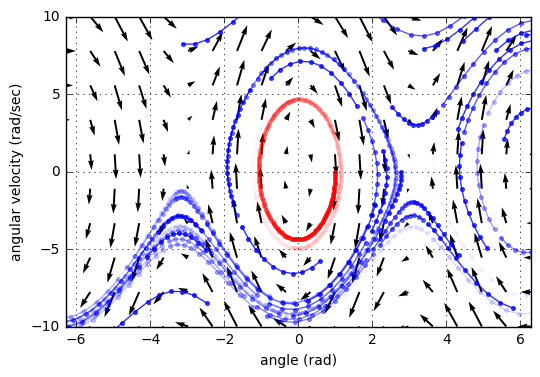

In [99]:
plt.figure(1); plt.grid('on')

alim = (-2*np.pi,2*np.pi)
dalim = (-10.,10.)

N = 20
T = 3*2*np.pi*np.sqrt(l/g)

np.random.seed(49)

A,dA = np.meshgrid(np.linspace(alim[0],alim[1],20),np.linspace(dalim[0],dalim[1],10))
A = A.flatten(); dA = dA.flatten(); ddA = 0.*dA
for k,(a,da) in enumerate(zip(A,dA)):
    ddA[k] = f(0.,[a,da],0.)[1]
plt.quiver(A,dA,dA,ddA)

for n in range(N):
    x1 = (np.random.rand()*np.diff(alim)+alim[0],
          np.random.rand()*np.diff(dalim)+dalim[0])
    _,trj = sim(f,T,x1,dt=4e-2)
    L = len(trj)/10
    for k in range(10):
        plt.plot(trj[k*L:(k+1)*L,0],trj[k*L:(k+1)*L,1],'b.-',alpha=(1.-((k+1.)/10.))**2)

        
L = len(x_)/10
for k in range(10):
    plt.plot(x_[k*L:(k+1)*L,0],x_[k*L:(k+1)*L,1],'r.-',alpha=(1.-((k+1.)/10.))**2)
    
plt.xlabel('angle (rad)'); plt.ylabel('angular velocity (rad/sec)')
plt.xlim(alim); plt.ylim(dalim)

In [81]:
%run _anim

In [88]:
fig, ax = plt.subplots(figsize=(4,4)); ax.axis('equal'); ax.grid('on');

line, = ax.plot([], [], 'r.-', lw=4, ms=20);

# initialization -- called once
def init():
    line.set_data([], [])
    ax.set_xlim(( -1., 1.))
    ax.set_ylim(( -1., 1.))
    return (line,)

# animation -- called iteratively
def animate(t):
    j = (t_ >= t).nonzero()[0][0]
    th = x_[j,0]
    x = np.array([0.,l*np.sin(th)])
    y = np.array([0.,-l*np.cos(th)])
    line.set_data(x, y)
    return (line,)

plt.close(fig)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                        frames=np.arange(0.,t_[-1],.1), interval=1, blit=True)

# Linearization 

If we're given the derivative of the vector field function with respect to state, then we can approximate the linearization along a simulation trajectory.  Let's start with $D_x f$, the (Jacobian) derivative of the vector field $f$ with respect to the state $x = (a,\dot{a})$:
$$D_x f(x,u) = \left[ \begin{array}{cc} 0 & 1 \\ -\frac{g}{l}\cos(a) & 0 \end{array} \right]$$

In [8]:
def Dxf(x):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([[0.,1.],[-(g/l)*np.cos(a),0.]])

Let's verify this is the derivative using finite-central-differences; we'll write a function that applies to general $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
$$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$

In [9]:
def D(g,y,d=1e-4):
    e = np.identity(len(y))
    Dyg = []
    for j in range(len(y)):
        Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
    return np.array(Dyg).T

Then we'll check that we get (approximately) the same result with the two methods (repeatedly press "Ctrl + Enter" to check at new random state):

In [13]:
x = np.random.randn(2)
print Dxf(x)
print D(lambda x : f(0.,x,0.), x, d=1e-6)

[[  0.          1.       ]
 [-19.5254519   0.       ]]
[[  0.          1.       ]
 [-19.5254519   0.       ]]


Note that finite-central-differences is sensitive to the "displacement" parameter:

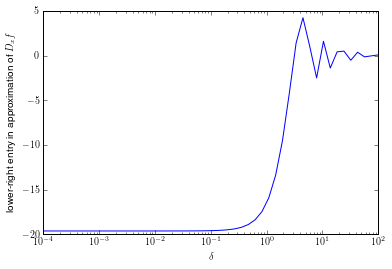

In [10]:
d = np.logspace(-4,2)
Dd = np.asarray([D(lambda x : f(0.,x,0.), x0, d=dd) for dd in d])
Dd.shape = (len(d),4)
plt.plot(d,Dd[:,2])
plt.xscale('log')
plt.xlabel('$\\delta$')
plt.ylabel('lower-right entry in approximation of $D_x f$')

Now to linearize along a trajectory, we need to define an auxiliary linear time-varying ODE:
$$\dot{X}(s) = F(s,X(s)) = A(s) X(s),\ X(0) = I,\ A(s) = D_x f(x(s),u(s)).$$

In [11]:
def F(s,X,u): # assumes 0 <= s <= t
    j = np.int(s/dt)
    As = Dxf(x_[j]) # note: we're evaluating Dxf along the simulation x_
    return np.dot(As,X)

Then we can apply the same simulation algorithm to this (linear time-varying) ODE (i.e. the simulation algorithm doesn't need to know the system is LTV):

In [12]:
X1 = np.identity(2)
T_,X_ = sim(F,t1,X1,u1)

For convenience, we can define a simulation function $\psi:\mathbb{N}\times\mathbb{R}^2\times U^\mathbb{R}\rightarrow \mathbb{R}^2$ that approximates the flow $\phi:\mathbb{R}\times\mathbb{R}^2\times U^\mathbb{R}\rightarrow \mathbb{R}^2$:

In [13]:
def psi(t,x,u=lambda t:0.):
    t_,x_ = sim(f,t,x,u)
    return x_[-1]

If we haven't made a mistake, then $D_x\phi(t,x) \approx D_x\psi(t,x) \approx X(t)$:

In [14]:
print X_[-1]
print D(lambda x : psi(t1,x,u1), x1, d=1e-6)

[[ 0.64738732 -0.09271757]
 [ 4.16244109  0.95187255]]
[[ 0.64740119 -0.09271651]
 [ 4.16248554  0.95185257]]


Wow -- agreement to 3 significant figures!

We have already linearized the system's vector field around an "interesting" equilibrium:

In [15]:
print 'x0 = \n',x0
print ''
print 'f(x0) = \n',f(0,x0,0)
print ''
print 'Dxf(x0) = \n',Dxf(x0)

x0 = 
[0, 0]

f(x0) = 
[ 0.  0.]

Dxf(x0) = 
[[  0.     1.  ]
 [-19.62   0.  ]]


Now let's linearize with respect to the input, and linearize the output function as well with respect to state and input:

In [16]:
def Duf(x):
    return np.asarray([0.,1.])

def Dxh(x):
    return np.asarray([1.,0.])

def Duh(x):
    return np.asarray([0.])

Let's define the system matrices for the resulting linear time-invariant system:
$$\dot{\xi} = A \xi + B \mu,\ \eta = C \xi + D \mu$$

In [17]:
A = Dxf(x0)
B = Duf(x0)
C = Dxh(x0)
D = Duh(x0)
print A,B,C,D

[[  0.     1.  ]
 [-19.62   0.  ]] [ 0.  1.] [ 1.  0.] [ 0.]


To simulate this linear time-invariant system, we need to define a new vector field function in the form expected by the simulation algorithm:

In [18]:
def fx0(t,x,u):
    # my convention in software is that x is a row vector,
    # so A x in math translates to np.dot(x,A.T) in code
    return np.dot(x,A.T) + np.dot(u,B.T)

def hx0(t,x,u):
    return np.dot(x,C.T) + np.dot(u,D.T)

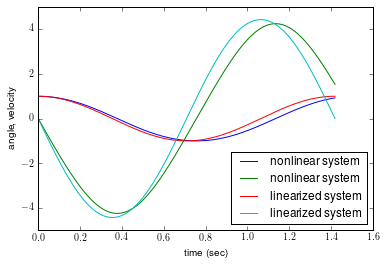

In [19]:
t1 = 2*np.pi*np.sqrt(l/g) # one period for linearized system
x1 = [1.,0.] # "interesting" initial condition
u1 = lambda t : 0 # zero input function

t0_,x0_ = sim(fx0,t1,x1,u1)

plt.plot(t_,x_,label='nonlinear system')
plt.plot(t0_,x0_,label='linearized system')
plt.legend(loc='lower right')
plt.xlabel('time (sec)')
plt.ylabel('angle, velocity')

Now we can compare against the result obtained using the matrix exponential formula:
$$x(t) = e^{A t}x(0).$$

In [20]:
import scipy as sp
from scipy import linalg as la

eAtx0_ = np.asarray([np.dot(x1,la.expm(A*t).T) for t in t0_])

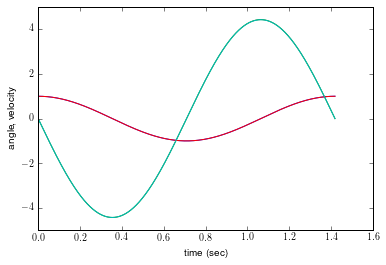

In [21]:
plt.plot(t0_,x0_,label='linearized system (simulation)')
plt.plot(t0_,eAtx0_,label='linearized system (trajectory)')
plt.xlabel('time (sec)')
plt.ylabel('angle, velocity')

With our stepsize, these traces coincide almost exactly; taking their difference, we can discern the discrepancy:

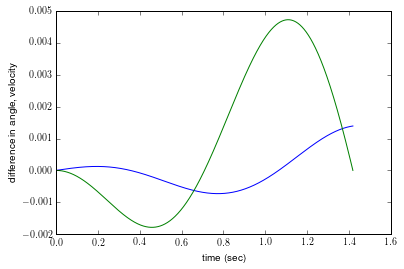

In [22]:
plt.plot(t0_,x0_-eAtx0_)
plt.xlabel('time (sec)')
plt.ylabel('difference in angle, velocity')

Again we see agreement to ~3 significant figures!

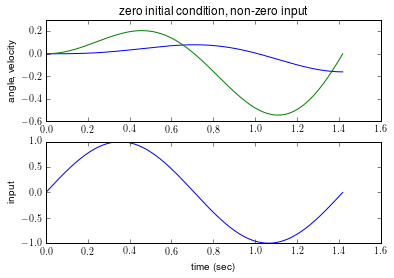

In [23]:
t2 = 2*np.pi*np.sqrt(l/g) # one period for linearized system
x2 = [0.,0.] # zero initial condition
u2 = lambda t : np.sin(t*2*np.pi/t2) # non-zero input function

t2_,x2_ = sim(fx0,t2,x2,u2)

plt.subplot(2,1,1)
plt.plot(t2_,x2_)
plt.ylabel('angle, velocity')
plt.title('zero initial condition, non-zero input')
plt.subplot(2,1,2)
plt.plot(t2_,u2(t2_))
plt.ylabel('input')
plt.xlabel('time (sec)')

Now let's compute the Jordan form of our $A$ matrix:

In [24]:
la.eigvals(A)

array([ 0.+4.42944692j,  0.-4.42944692j])

Since the eigenvalues are distinct, the Jordan form is diagonal:
$$J = \operatorname{diag}\operatorname{spec} A = \left[\begin{array}{cc} \lambda_1 & 0 \\ 0 & \lambda_2 \end{array}\right].$$

In [25]:
J = np.diag(la.eigvals(A))
print J

[[ 0.+4.42944692j  0.+0.j        ]
 [ 0.+0.j          0.-4.42944692j]]


If $J = P^{-1} A P$, then the $i$-th column of $P$ is the eigenvector corresponding to the $i$-th eigenvalue along the diagonal of $J$.

In [26]:
_,P = la.eig(A) # second value returned is the matrix of eigenvectors of A
np.dot(la.inv(P),np.dot(A,P)) # if the eigenvalues are distinct, this is the Jordan form of A

array([[ 0.+4.42944692j,  0.+0.j        ],
       [ 0.+0.j        ,  0.-4.42944692j]])

This is the same as our matrix $J$:

In [27]:
np.allclose(J,np.dot(la.inv(P),np.dot(A,P)))

True

Now the matrix exponential $e^{At}$ can be computed using the much simpler $e^{At} = P e^{Jt} P^{-1}$:

In [28]:
def eJ(t):
    return np.diag(np.exp(la.eigvals(A)*t))
np.allclose(la.expm(A*t1),np.dot(P,np.dot(eJ(t1),la.inv(P))))

True

Let's try computing $e^{At}$ using a truncated power series (Method 1 in MolerLoan2003):
$$e^{At} \approx I + A + A^2/2! + \cdots + A^k / k!$$

In [29]:
from scipy.misc import factorial

def eA(t,k):
    # compute the first k powers of A
    Ak = [np.identity(A.shape[0])]
    for j in range(1,k):
        Ak.append(np.dot(A,Ak[-1]))
    # compute the first k terms in the power series of e^{At}
    eAt = np.zeros(A.shape)
    for j in range(k):
        eAt += (t**j) * Ak[j] / factorial(j)
    return eAt

# for my matrix, need to use 5 terms to get agreement to 2 significant figures
t = 0.2
print la.expm(A*t)
print eA(t,5)

[[ 0.63260094  0.17484754]
 [-3.43050883  0.63260094]]
[[ 0.63326296  0.17384   ]
 [-3.4107408   0.63326296]]


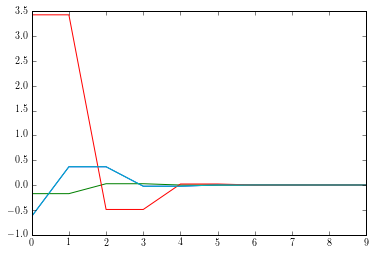

In [30]:
# with this time horizon, the error decreases as the number of terms increase:
t = .2
K = np.arange(10)
eAt = la.expm(A*t)
plt.plot(K,[(eA(t,k) - eAt).flatten() for k in K])

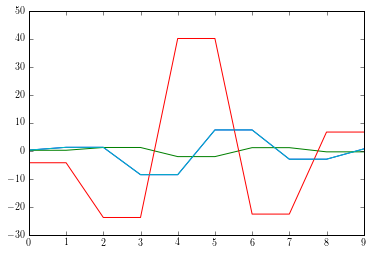

In [31]:
# but with a longer time horizon horizon, the error INCREASES as the number of terms increase:
t = 1.0
K = np.arange(10)
eAt = la.expm(A*t)
plt.plot(K,[(eA(t,k) - eAt).flatten() for k in K])

Note that we can approximate $e^{At}$ by numerically simulating the linearized ODE $\dot{\xi} = A\xi$ from each of the standard Euclidean basis vectors (Method 5 in MolerLoan2003):

In [32]:
t = 0.2
print np.array([sim(fx0,t,e)[1][-1] for e in np.identity(A.shape[0])]).T
print la.expm(A*t)

[[ 0.63272512  0.17488184]
 [-3.4311818   0.63272512]]
[[ 0.63260094  0.17484754]
 [-3.43050883  0.63260094]]


This works well even on longer time horizons:

In [33]:
t = 1.0
print np.array([sim(fx0,t,e)[1][-1] for e in np.identity(A.shape[0])]).T
print la.expm(A*t)

[[-0.27945622 -0.21699788]
 [ 4.25749844 -0.27945622]]
[[-0.27918193 -0.21678513]
 [ 4.25332424 -0.27918193]]


# Controllability

Now let's assemble the controllability matrix:
$$C = \left[\begin{array}{ccccc} B & AB & A^2 B & \cdots & A^{n-1} B \end{array}\right].$$
Note that $n = 2$ for our system and $B = b\in\mathbb{R}^{n\times 1}$, so our controllability matrix simplifies to:
$$C = \left[\begin{array}{ccccc} b & Ab \end{array}\right].$$

In [34]:
b = B
C = np.asarray([b,np.dot(b,A.T)]).T
print 'C = \n',C

C = 
[[ 0.  1.]
 [ 1.  0.]]


This matrix is obviously full rank.  However, it's instructive to apply an algorithm -- Singular Value Decomposition (SVD) -- to compute the rank of $C$ and obtain a basis for the controllable subspace (i.e. the rangespace of $C$):

In [35]:
svd = np.linalg.svd

U,s,V = svd(C)
print 'U = \n',U
print 's = \n',s
print 'V = \n',V

U = 
[[ 0. -1.]
 [-1.  0.]]
s = 
[ 1.  1.]
V = 
[[-1. -0.]
 [-0. -1.]]


If any singular values in $s$ were (approximately) zero, the corresponding columns of $U$ would provide a basis for the uncontrollable subspace; the remaining columns would provide a basis for the controllable subspace.

In [36]:
A_ = np.zeros((2,2))
b_ = np.array([1.,0])
C_ = np.asarray([b_,np.dot(b_,A_.T)]).T
print 'C_ = \n',C_
U_,s_,V_ = svd(C_)
print 'U_ = \n',U_
print 's_ = \n',s_
print 'V_ = \n',V_

# since s_[0] is not zero, U_[:,0] lies in the controllable subspace
# since s_[1] is zero, U_[:,1] lies in the uncontrollable subspace

C_ = 
[[ 1.  0.]
 [ 0.  0.]]
U_ = 
[[ 1.  0.]
 [ 0.  1.]]
s_ = 
[ 1.  0.]
V_ = 
[[ 1.  0.]
 [ 0.  1.]]


The SVD works even when the controllability matrix $C$ is not square:

In [37]:
A_ = np.zeros((2,2))
b_ = np.array([[1.,0],[0.,1.]])
C_ = np.vstack([b_,np.dot(b_,A_.T)]).T
print 'C_ = \n',C_
U_,s_,V_ = svd(C_)
print 'U_ = \n',U_
print 's_ = \n',s_
print 'V_ = \n',V_

C_ = 
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]]
U_ = 
[[ 1.  0.]
 [ 0.  1.]]
s_ = 
[ 1.  1.]
V_ = 
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


Note that controllability is a generic property of pairs $(A,b)$, i.e. if we select $A$ and $b$ at random and construct the controllability matrix, it will have full rank (its singular values will be distinct from zero):

In [38]:
A_ = np.random.randn(2,2)
b_ = np.random.randn(2)
C_ = np.vstack([b_,np.dot(b_,A_.T)]).T
print 'C_ = \n',C_
U_,s_,V_ = svd(C_)
print 'U_ = \n',U_
print 's_ = \n',s_
print 'V_ = \n',V_
print '(A_,b_) controllable?  ',not np.allclose(s_,np.zeros(2))

C_ = 
[[-1.0772801   0.66943571]
 [-0.57045499  1.59934854]]
U_ = 
[[-0.56844552 -0.82272091]
 [-0.82272091  0.56844552]]
s_ = 
[ 2.0118888   0.66656935]
V_ = 
[[ 0.53765411 -0.8431655 ]
 [ 0.8431655   0.53765411]]
(A_,b_) controllable?   True


Thus lack of controllability arises in practice due to structural properties of the control system under investigation, e.g. parallel interconnection of identical systems -- see Sec 11.2 in textbook.

# Stability and stabilization

Now let's investigate the stability properties of (CLTI) systems obtained by linearizing the pendulum about different equilibria.

Note that both $x_0 = (0,0)$ and $x_1 = (\pi,0)$ are equilibria of the nonlinear system:

In [39]:
x0 = [0.,0.]
x1 = [np.pi,0.]
print 'f(x0) =',f(0.,x0,0.)
print 'f(x1) =',f(0.,x1,0.)

f(x0) = [ 0.  0.]
f(x1) = [  0.00000000e+00  -2.40275702e-15]


Let's investigate the (CLTI) systems obtained by linearizing about both equilibria:
$$\text{(CLTI-0):}\ \dot{\xi} = A_0 \xi + B_0 \mu,\ \eta = C_0 \xi + D_0 \mu;$$
$$\text{(CLTI-1):}\ \dot{\xi} = A_1 \xi + B_1 \mu,\ \eta = C_1 \xi + D_1 \mu.$$

In [40]:
A0 = Dxf(x0)
# this time I'm careful to ensure B is a column vector
B0 = Duf(x0)[:,np.newaxis]
C0 = Dxh(x0)
D0 = Duh(x0)
print 'A =\n',A0,'\n','B =\n',B0,'\n','C =\n',C0,'\n','D =\n',D0,'\n'

A1 = Dxf(x1)
B1 = Duf(x1)[:,np.newaxis]
C1 = Dxh(x1)
D1 = Duh(x1)
print A1,'\n',B1,'\n',C1,'\n',D1,'\n'

A =
[[  0.     1.  ]
 [-19.62   0.  ]] 
B =
[[ 0.]
 [ 1.]] 
C =
[ 1.  0.] 
D =
[ 0.] 

[[  0.     1.  ]
 [ 19.62   0.  ]] 
[[ 0.]
 [ 1.]] 
[ 1.  0.] 
[ 0.] 



First let's check the stability properties using the eigenvalue test:

In [41]:
spec0 = np.linalg.eigvals(A0)
spec1 = np.linalg.eigvals(A1)
print spec0
print spec1

[ 0.+4.42944692j  0.-4.42944692j]
[ 4.42944692 -4.42944692]


Let's see if our analytical reasoning is preserved numerically:

In [42]:
print np.linalg.eigvals(la.expm(A0)), np.abs(np.linalg.eigvals(la.expm(A0)))

[-0.27918193+0.96023822j -0.27918193-0.96023822j] [ 1.  1.]


The eigenvalues of $A_0$ lie on the imaginary axis, and none are repeated, so (CLTI-0) is *marginally stable*.

One of the eigenvalues of $A_1$ lies in the right-half complex plane, so (CLTI-1) is *unstable*.

Before we proceed with constructing stabilizing control inputs, we should verify our systems are controllable; we already did this for (CLTI-0), but we'll repeat the computation here for completeness:

In [43]:
C0 = np.hstack([B0,np.dot(A0,B0)])
C1 = np.hstack([B1,np.dot(A1,B0)])
print 'C0 = \n',C0
print 'C1 = \n',C1

C0 = 
[[ 0.  1.]
 [ 1.  0.]]
C1 = 
[[ 0.  1.]
 [ 1.  0.]]


Both are clearly full rank, so both systems are controllable.

Now let's stabilize the systems from an "interesting" initial condition $x_2 = (\pi/2,0)$.

In [44]:
x2 = [np.pi/2,0.]

**NOTE:** $x_2$ is an initial condition for the original pendulum model; to obtain an initial condition for the (CLTI) systems, we must *translate* it relative to the corresponding equilibria, i.e. for $j \in \{0,1\}$ the initial condition for (CLTI-j) will be $\xi_j = x_2 - x_j$.

In the case where $j = 0$ we know $x_j = x_0 = (0,0)$, so this doesn't actually alter the vector; for $j = 1$ however this will shift the position by $\pi$.

In [45]:
# BE CAREFUL !!!
print x2+x0
print 5*x0

[1.5707963267948966, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [47]:
# This results in an error
#xi0 = x2 - x0
#xi1 = x2 - x1

If you get this kind of error, the issue is that $x_2$ and $x_0$ are Python lists, not Numpy arrays; fortunately there's an easy fix:

In [48]:
x2 = np.array(x2)
xi0 = x2 - x0
xi1 = x2 - x1
print x2+x0
print 5*x2

[ 1.57079633  0.        ]
[ 7.85398163  0.        ]


## Finite-time stabilization

To derive the finite-time stabilizing input from Theorem 11.3 in the textbook, we need to fix the time horizon $t > 0$ and compute the reachability Gramian $W(t)$.
Recalling that the reachability Gramian for a (CLTI) system is
$$W(t) = \int_{0}^{t} e^{A(t-\tau)} B B^T e^{A^T(t-\tau)} d\tau,$$
by differentiating with respect to $t$ we see that $W$ satisfies the matrix-valued LTI ODE
$$\dot{W} = B B^T + A W + W A^T,\ W(0) = 0.$$
Therefore to compute $W(t)$ we can simulate this ODE.

In [49]:
# start by defining a function that will work with any pair (A,B)
def FW(s,W,u,A,B): 
    return np.dot(B,B.T) + np.dot(A,W) + np.dot(W,A.T)
# then wrap the general function by passing our particular (A0,B0)
FW0 = lambda s,W,u : FW(s,W,u,A0,B0)
# now we initialize and simulate to approximate the Gramian
t = 1.
W00 = np.zeros((2,2))
_,W0_ = sim(FW0,t,W00)
W0t = W0_[-1]

Now we can use our approximation for $W_j(t)$ to synthesize an open-loop input that should take the initial condition $\xi_j$ to the origin at time $t$:
$$\forall s\in[0,t] : \mu_j(s) = -B_j^T e^{A_j^T(t-s)} W_j(t)^{-1}e^{A t} \xi_j.$$
For convenience, and to ensure we don't need to invert $W(t)$ at every timestep of the simulation, we'll define
$$\eta_j = -W_j(t)^{-1}e^{A t}\xi_j.$$

In [50]:
# note: eta is a column vector
eta0 = np.dot(np.dot(-xi0,la.expm(t*A0.T)),np.linalg.inv(W0t).T)[:,np.newaxis]

Now we'll run a simulation with this input applied:

xi(t) = [ 0.00127151  0.00514541]


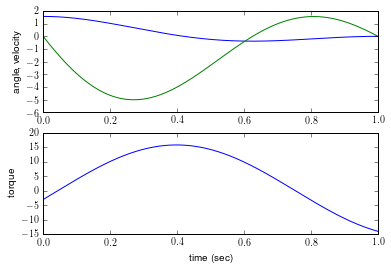

In [51]:
f0 = lambda s,xi,mu : (np.dot(xi,A0.T) + np.dot(mu,B0.T)).flatten()

mu0 = lambda s : np.dot(B.T,np.dot(la.expm(A0.T*(t-s)),eta0))

t_,xi0_ = sim(f0,t,xi0,mu0)

print 'xi(t) =',xi0_[-1]

plt.figure()
plt.subplot(211)
plt.plot(t_,xi0_)
plt.ylabel('angle, velocity')
plt.subplot(212)
plt.plot(t_,[mu0(s) for s in t_])
plt.ylabel('torque')
plt.xlabel('time (sec)')

The result is pretty good -- both states are zero to 2 decimal places!

Now we'll apply the same strategy to to (CLTI-1).

Since this is an unstable system, the results aren't as good -- even if I halve the time horizon the final states are only zero to 1 decimal place:

xi(t) = [ 0.02125063  0.09539638]


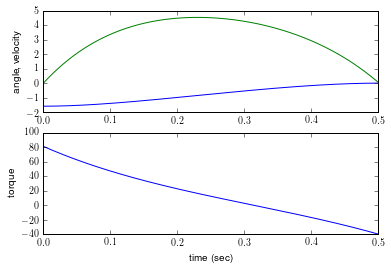

In [52]:
FW1 = lambda s,W,u : FW(s,W,u,A1,B1)

t = .5
W10 = np.zeros((2,2))
_,W1_ = sim(FW1,t,W10)
W1t = W1_[-1]

eta1 = np.dot(np.dot(-xi1,la.expm(t*A1.T)),np.linalg.inv(W1t).T)[:,np.newaxis]

f1 = lambda s,xi,u : (np.dot(xi,A1.T) + np.dot(u,B1.T)).flatten()

mu1 = lambda s : np.dot(B.T,np.dot(la.expm(A1.T*(t-s)),eta1))
t_,xi1_ = sim(f1,t,xi1,mu1)

print 'xi(t) =',xi1_[-1]

plt.figure()
plt.subplot(211)
plt.plot(t_,xi1_)
plt.ylabel('angle, velocity')
plt.subplot(212)
plt.plot(t_,[mu1(s) for s in t_])
plt.ylabel('torque')
plt.xlabel('time (sec)')

What happens when we perturb the trajectory, i.e. interrupt the simulation, change the state, and continue simulating with the same open-loop input?

To make this easy to implement, we'll need to modify the simulation function to accept both an initial and final time:

In [53]:
def sim(f,t,x,u=lambda t:0.,dt=1e-4,t0=0.):
    j,t_,x_ = 0,[t0],[x]
    while t_[-1]+dt < t:
        x_.append(x_[-1] + dt*f(t_[-1],x_[-1],u(t_[-1])))
        t_.append(t_[-1]+dt)
        j += 1
    return np.array(t_),np.array(x_)

In [54]:
FW1 = lambda s,W,u : FW(s,W,u,A1,B1)

t = .5

# perturbation time and state displacement
tpert = t/2.
pert = np.random.randn(2)

W10 = np.zeros((2,2))
_,W1_ = sim(FW1,t,W10)
W1t = W1_[-1]

eta1 = np.dot(np.dot(-xi1,la.expm(t*A1.T)),np.linalg.inv(W1t).T)[:,np.newaxis]

f1 = lambda s,xi,u : (np.dot(xi,A1.T) + np.dot(u,B1.T)).flatten()

mu1 = lambda s : np.dot(B.T,np.dot(la.expm(A1.T*(t-s)),eta1))

t_,xi1_ = sim(f1,tpert,xi1,mu1)

t_un,xi1_un = sim(f1,t,xi1_[-1],mu1,t0=tpert)
t_pert,xi1_pert = sim(f1,t,xi1_[-1]+pert,mu1,t0=tpert)

t_un = np.hstack((t_,t_un))
xi1_un = np.vstack((xi1_,xi1_un))
t_pert = np.hstack((t_,t_pert))
xi1_pert = np.vstack((xi1_,xi1_pert))

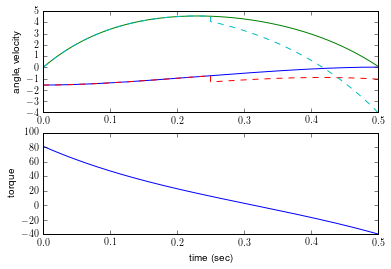

In [55]:
plt.figure()
plt.subplot(211)
plt.plot(t_un,xi1_un)
plt.plot(t_pert,xi1_pert,'--')
plt.ylabel('angle, velocity')
plt.subplot(212)
plt.plot(t_un,[mu1(s) for s in t_un])
plt.ylabel('torque')
plt.xlabel('time (sec)')

## Asymptotic stabilization

Now let's synthesize state feedback laws that asymptotically stabilize these (CLTI) systems.

Following the procedure from Lecture 12.4 in the textbook, we first need to determine constants $\mu_j > 0$ so that $- \mu_j I - A_j$ is a stability matrix, i.e. $\operatorname{spec}(- \mu_j I - A_j) \subset\mathbb{C}_o^-$.

To determine appropriate values of $\mu_j$, we can plot the max of the real parts of the eigenvalues of $- \mu_j I - A_j$ vs $\mu_j$:

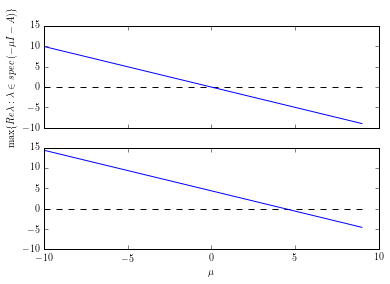

In [56]:
mus = np.arange(-10,10)

fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
#plt.subplot(211)
ax[0].plot(mus,0*mus,'k--')
ax[0].plot(mus,[la.eigvals(-mu*np.identity(2)-A0).real.max() for mu in mus])
#plt.subplot(212)
ax[1].plot(mus,0*mus,'k--')
ax[1].plot(mus,[la.eigvals(-mu*np.identity(2)-A1).real.max() for mu in mus])
ax[0].set_ylabel(r'$\max\{Re\lambda : \lambda\in {spec}\ (-\mu I - A)\}$')
ax[1].set_xlabel(r'$\mu$')

So if $\mu_0 > 0$ then $-\mu_0I - A_0$ is stable and if $\mu_1 > 5$ then $-\mu_1 I - A_1$ is stable.

In [57]:
mu0 = 1.
mu1 = 6.

Now we solve the Lyapunov equation in Eqn (12.12) in the textbook as indicated by Hint 31:

In [58]:
from control import lyap

W0 = lyap(-mu0*np.identity(2)-A0,np.dot(B0,B0.T))
W1 = lyap(-mu1*np.identity(2)-A1,np.dot(B1,B1.T))

Now the stabilizing state feedback law is $u = - K x$ where $K = \frac{1}{2} B^T W^{-1}$:

In [59]:
K0 = .5*np.dot(B0.T,la.inv(W0))
K1 = .5*np.dot(B1.T,la.inv(W1))

There are two ways we could simulate the result of applying this feedback law:
1. we could simulate the closed-loop (CLTI) system obtained by introducing this state feedback law;
2. we could modify the sim() function to allow inputs that depend on both time and state.

The former is straightforward algebraically, but doesn't easily allow us to apply the state feedback law to the nonlinear system, whereas the latter enables us to do that directly.  I'll implement both methods as a tutorial.

xi(t) = [-0.00956623  0.03321461]


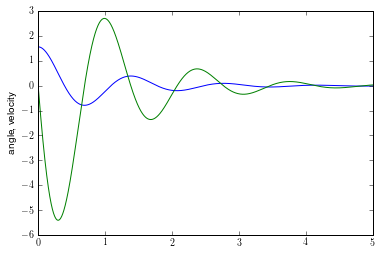

In [60]:
A0_B0K0 = A0 - np.dot(B0,K0)

f0cl = lambda s,xi,u : (np.dot(xi,A0_B0K0.T)).flatten()

# we'll need to simulate longer to see the asymptotic stabilization at work
t = 5.

t_,xi0_ = sim(f0cl,t,xi0)

print 'xi(t) =',xi0_[-1]

plt.plot(t_,xi0_)
plt.ylabel('angle, velocity')

In [61]:
# this sim() function expects inputs that depend on time and state
def sim(f,t,x,u=lambda t,x:0.,dt=1e-4,t0=0.):
    j,t_,x_ = 0,[t0],[x]
    while t_[-1]+dt < t:
        x_.append(x_[-1] + dt*f(t_[-1],x_[-1],u(t_[-1],x_[-1])))
        t_.append(t_[-1]+dt)
        j += 1
    return np.array(t_),np.array(x_)

xi(t) = [-0.00956623  0.03321461]


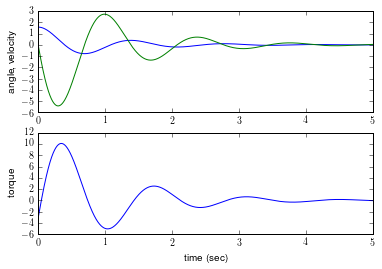

In [62]:
t = 5.
mu0 = lambda t,x : -np.dot(x,K0.T)

t_,xi0_ = sim(f0,t,xi0,mu0)

print 'xi(t) =',xi0_[-1]

plt.figure()
plt.subplot(211)
plt.plot(t_,xi0_)
plt.ylabel('angle, velocity')
plt.subplot(212)
plt.plot(t_,[mu0(s,xi) for s,xi in zip(t_,xi0_)])
plt.ylabel('torque')
plt.xlabel('time (sec)')

xi(t) = [-0.00012991 -0.00051907]


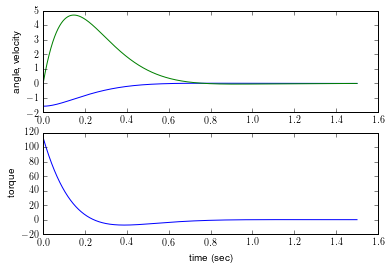

In [63]:
t = 1.5
mu1 = lambda t,x : -np.dot(x,K1.T)

t_,xi1_ = sim(f1,t,xi1,mu1)

print 'xi(t) =',xi1_[-1]

plt.figure()
plt.subplot(211)
plt.plot(t_,xi1_)
plt.ylabel('angle, velocity')
plt.subplot(212)
plt.plot(t_,[mu1(s,xi) for s,xi in zip(t_,xi1_)])
plt.ylabel('torque')
plt.xlabel('time (sec)')

Now that we've implemented both finite-time and asymptotic stabilization control laws, it's instructive to apply both to the original nonlinear system.

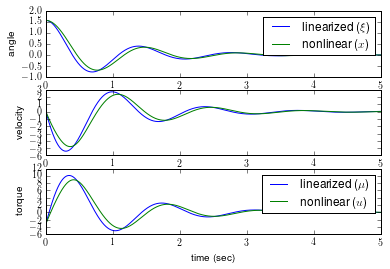

In [64]:
t = 5.

x2 = np.array([np.pi/2,0.])
xi0 = x2 - x0

mu0 = lambda t,x : -np.dot(x,K0.T)
u0 = lambda t,x : -np.dot(np.array(x)-x0,K0.T)

t_,xi0_ = sim(f0,t,xi0,mu0)
t_,x0_ = sim(f,t,x2,u0)

plt.figure()
plt.subplot(311)
plt.plot(t_,(xi0_+x0)[:,0],label=r'linearized ($\xi$)')
plt.plot(t_,x0_[:,0],label=r'nonlinear ($x$)')
plt.legend()
plt.ylabel('angle')
plt.subplot(312)
plt.plot(t_,(xi0_+x0)[:,1])
plt.plot(t_,x0_[:,1])
plt.ylabel('velocity')
plt.subplot(313)
plt.plot(t_,[mu0(s,xi) for s,xi in zip(t_,xi0_)],label=r'linearized ($\mu$)')
plt.plot(t_,[u0(s,x) for s,x in zip(t_,x0_)],label=r'nonlinear ($u$)')
plt.legend()
plt.ylabel('torque')
plt.xlabel('time (sec)')

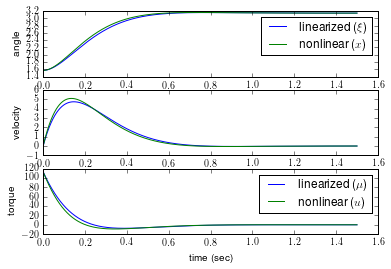

In [65]:
t = 1.5

x2 = np.array([np.pi/2,0.])
xi0 = x2 - x0
xi1 = x2 - x1

mu1 = lambda t,x : -np.dot(x,K1.T)
u1 = lambda t,x : -np.dot(np.array(x)-x1,K1.T)

t_,xi1_ = sim(f1,t,xi1,mu1)
t_,x1_ = sim(f,t,x2,u1)

plt.figure()
plt.subplot(311)
plt.plot(t_,(xi1_+x1)[:,0],label=r'linearized ($\xi$)')
plt.plot(t_,x1_[:,0],label=r'nonlinear ($x$)')
plt.legend()
plt.ylabel('angle')
plt.subplot(312)
plt.plot(t_,(xi1_+x1)[:,1])
plt.plot(t_,x1_[:,1])
plt.ylabel('velocity')
plt.subplot(313)
plt.plot(t_,[mu1(s,xi) for s,xi in zip(t_,xi1_)],label=r'linearized ($\mu$)')
plt.plot(t_,[u1(s,x) for s,x in zip(t_,x1_)],label=r'nonlinear ($u$)')
plt.legend()
plt.ylabel('torque')
plt.xlabel('time (sec)')

Now let's perturb both systems and observe the result:

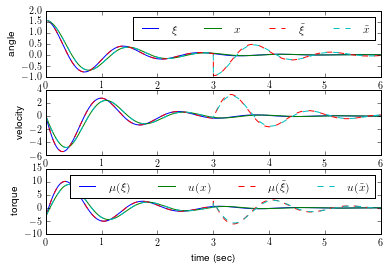

In [66]:
t = 6.

tpert = t/2.
pert = [-1.,0.]

x2 = np.array([np.pi/2,0.])
xi0 = x2 - x0

mu0 = lambda t,x : -np.dot(x,K0.T)
u0 = lambda t,x : -np.dot(np.array(x)-x0,K0.T)

t_,xi0_ = sim(f0,tpert,xi0,mu0)
t_,x0_ = sim(f,tpert,x2,u0)

t_un,xi0_un = sim(f0,t,xi0_[-1],mu0,t0=tpert)
t_un,x0_un  = sim(f, t,x0_[-1], u0, t0=tpert)

t_pert,xi0_pert = sim(f0,t,xi0_[-1]+pert,mu0,t0=tpert)
t_pert,x0_pert  = sim(f, t,x0_[-1]+pert, u0, t0=tpert)

t_un = np.hstack((t_,t_un))
xi0_un = np.vstack((xi0_,xi0_un))
x0_un = np.vstack((x0_,x0_un))
t_pert = np.hstack((t_,t_pert))
xi0_pert = np.vstack((xi0_,xi0_pert))
x0_pert = np.vstack((x0_,x0_pert))

plt.figure()
plt.subplot(311)
plt.plot(t_un,(xi0_un+x0)[:,0],label=r'$\xi$')
plt.plot(t_un,x0_un[:,0],label=r'$x$')
plt.plot(t_pert,(xi0_pert+x0)[:,0],'--',label=r'$\tilde{\xi}$')
plt.plot(t_pert,x0_pert[:,0],'--',label=r'$\tilde{x}$')
plt.ylabel('angle')
plt.legend(ncol=4,loc='upper right')
plt.subplot(312)
plt.plot(t_un,(xi0_un+x0)[:,1],label=r'$\xi$')
plt.plot(t_un,x0_un[:,1],label=r'$x$')
plt.plot(t_pert,(xi0_pert+x0)[:,1],'--',label=r'$\tilde{\xi}$')
plt.plot(t_pert,x0_pert[:,1],'--',label=r'$\tilde{x}$')
plt.ylabel('velocity')
plt.subplot(313)
plt.plot(t_un,[mu0(s,xi) for s,xi in zip(t_un,xi0_un)],label=r'$\mu(\xi)$')
plt.plot(t_un,[u0(s,x) for s,x in zip(t_un,x0_un)],label=r'$u(x)$')
plt.plot(t_pert,[mu0(s,xi) for s,xi in zip(t_pert,xi0_pert)],'--',label=r'$\mu(\tilde{\xi})$')
plt.plot(t_pert,[u0(s,x) for s,x in zip(t_pert,x0_pert)],'--',label=r'$u(\tilde{x})$')
plt.legend(ncol=4)
plt.ylabel('torque')
plt.xlabel('time (sec)')

# Observability and state estimates

Now we move on to assessing observability of our (CLTI) system and estimating the state from the output, either in finite-time or asymptotically.

In [67]:
A = Dxf(x0)
B = Duf(x0)[:,np.newaxis]
C = Dxh(x0)[np.newaxis,:]
D = Duh(x0)
print A,'\n',B,'\n',C,'\n',D

[[  0.     1.  ]
 [-19.62   0.  ]] 
[[ 0.]
 [ 1.]] 
[[ 1.  0.]] 
[ 0.]


Let's assemble the observabiity matrix:
$$O = \left[\begin{array}{c} C \\ CA \\ CA^2 \\ \cdots \\ CA^{n-1} \end{array}\right].$$
Note that $n = 2$ for our system and $C = c\in\mathbb{R}^{1\times n}$, so our observability matrix simplifies to:
$$O = \left[\begin{array}{c} c \\ cA \end{array}\right].$$

In [68]:
c = C
O = np.vstack([c,np.dot(c,A)])
print 'O = \n',O

O = 
[[ 1.  0.]
 [ 0.  1.]]


This matrix is clearly fully rank, hence our (CLTI) system is observable.

Let's construct the final state of a simulation starting from an "interesting" initial condition using only the output signal.  Theorem 15.2 in the textbook provides a recipy for construction in terms of the *constructability Gramian*
$$W(t) = \int_0^t e^{A^T(\tau - t)} C^T C e^{A(\tau - t)} d\tau.$$
Given the output signal $y:[0,t]\rightarrow\mathbb{R}^m$ the final state may be constructed via
$$x(t) = W(t)^{-1}\int_0^t e^{A^T(\tau - t)} C^T \bar{y}(\tau) d\tau,$$
where $\bar{y}:[0,t]\rightarrow\mathbb{R}^m$ is the signal given by
$$\forall s\in[0,t] : \bar{y}(s) = y(s) - \int_0^t C e^{A(t - \tau)} B u(\tau) d\tau - D(s) u(s).$$

In [73]:
t = .5; dt = 1e-3*2e-0
f = lambda s,xi,u : (np.dot(A,xi[:,np.newaxis]) + np.dot(B,u)).flatten()
xi = xi0
t_,xi_ = sim(f0,t,xi,dt=dt)
# Riemann sum approximation for integral defining Gramian W(t)
Wt = sum([dt*np.dot(np.dot(la.expm(A.T*(dt*j-t)),np.dot(C.T,C)),
                    la.expm(A*(dt*j-t))) for j in range(len(t_))])
# since this simulation incorporated no input, y = \bar{y}
y = lambda j : np.dot(C,xi_[j][:,np.newaxis]).flatten()
# Riemann sum approximation for integral in state construction formula
I = sum([dt*np.dot(la.expm(A.T*(dt*j-t)),C.T)*y(j) for j in range(len(t_))])
# final state construction is simply product of Gramian inverse with integral
xit = np.dot(la.inv(Wt),I)

print 'xi(t) = \n',xi_[-1][:,np.newaxis],'\nxi(t) estimated =\n',xit

xi(t) = 
[[-0.94092279]
 [-5.65644784]] 
xi(t) estimated =
[[-0.94642412]
 [-5.57838938]]


Looks good -- agreement to 2 significant figures.

Now we wish to achieve asymptotic state estimation.  Following the procedure from Lecture 16.5 in the textbook, we first need to select $\mu > 0$ so that $(-\mu I - A)$ is a stable matrix; this is achievable with the same $\mu$ used to stabilize the system, above:

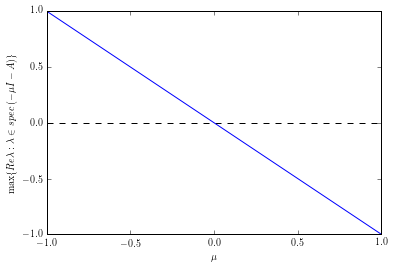

In [70]:
mus = np.arange(-1,2)

plt.plot(mus,0*mus,'k--')
plt.plot(mus,[la.eigvals(-mu*np.identity(2)-A).real.max() for mu in mus])
plt.ylabel(r'$\max\{Re\lambda : \lambda\in {spec}\ (-\mu I - A)\}$')
plt.xlabel(r'$\mu$')

In [71]:
mu = 1.
W = lyap(-mu*np.identity(2)-A.T,np.dot(C.T,C))
L = .5*np.dot(la.inv(W).T,C.T)
print la.eigvals(A - np.dot(L,C))

[-1.+4.54092502j -1.-4.54092502j]


Sure enough, this procedure yields a stable matrix.

With a suitable output-injection matrix $L$ computed, we can now implement the estimator.

The estimator consists of an auxiliary (CLTI) system driven by the output of the original (CLTI) system; the closed-loop system dynamics are given by:
$$\dot{\xi} = A \xi + B \mu,\ \eta = C \xi + D \mu;\\ \dot{\hat{\xi}} = A \hat{\xi} + B \mu - L(\hat{\eta} - \eta),\ \hat{\eta} = C \hat{\xi} + D\mu.$$

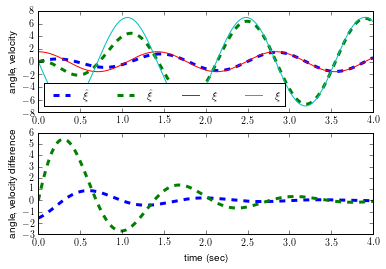

In [76]:
n = 2
def cl(s,xhx,u):
    xi,hxi = xhx[:n,np.newaxis],xhx[n:,np.newaxis]
    dxi  = (np.dot(A,xi)  + np.dot(B,u)).flatten()
    dhxi = (np.dot(A,hxi) + np.dot(B,u) - np.dot(L,np.dot(C,hxi)-np.dot(C,xi))).flatten()
    return np.hstack([dxi,dhxi])
t = 4.
xhx0 = np.hstack([xi,0.*xi])
t_,xhx_ = sim(cl,t,xhx0)

plt.subplot(211)
plt.plot(t_,xhx_[:,n:],'--',lw=3,label=r'$\hat{\xi}$')
plt.plot(t_,xhx_[:,:n],label=r'$\xi$')
plt.legend(ncol=4,loc='lower left')
plt.ylabel('angle, velocity')
plt.subplot(212)
plt.plot(t_,xhx_[:,n:]-xhx_[:,:n],'--',lw=3)
plt.ylabel('angle, velocity difference')
plt.xlabel('time (sec)')